In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
df = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


__Comments__:

- this dataset has data extracted from credit card transitions;


- the 3 know columns are:

    - __time__: the time elapsed between the transaction and the first transaction in the dataset;
    
    - __amount__: the amount of the transaction;
    
    - __class__: our target:
        - __0__: valid transaction
        - __1__: fraudulent transaction

In [3]:
# select data

X = df.drop(columns=['Class'], axis=1).values
y = df['Class'].values

# rebalancing classes

In [4]:
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
dtype: float64

__Comments__:

- the classes are extremely imbalanced:
    - 99.8% of normal transactions
    - 0.2% of fraudulent transactions
    
    
We won't be able to detect cases of fraud unless we apply some serious rebalancing strategies

__First__, we create three separate splits __Train/Val/Test__ from the dataset. It's extremely important to keep validation and testing sets __unbalanced__ so that when we evaluate our model, it is done in true conditions, without data leakage. The test set will be kept for the last part of the notebook.


__Second__, we rebalance our training set (only this one). We have many choices:

- simply oversample the minority class randomly using plain Numpy functions (not the best option since we are duplicating rows and hence creating data leakage);
    
- use __Synthetic Minority Oversampling Technique - SMOTE__ to generate new datapoints by weighting the existing ones;

- in addition, we can also try a __RandomUnderSampler__ to downsample the majority class a little bit.

## create train / val / test sets

In [5]:
from sklearn.model_selection import train_test_split

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_val.shape = {X_val.shape}')
print(f'y_val.shape = {y_val.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (139554, 30)
y_train.shape = (139554,)
X_val.shape = (59810, 30)
y_val.shape = (59810,)
X_test.shape = (85443, 30)
y_test.shape = (85443,)


In [6]:
pd.Series(y_train).value_counts()

0    139296
1       258
dtype: int64

In [7]:
# how many fraud samples do I have in each split

print(f'There are {pd.Series(y_train).value_counts()[1]} fraudulent transactions in the train set')
print(f'There are {pd.Series(y_val).value_counts()[1]} fraudulent transactions in the validation set')
print(f'There are {pd.Series(y_test).value_counts()[1]} fraudulent transactions in the test set')

There are 258 fraudulent transactions in the train set
There are 98 fraudulent transactions in the validation set
There are 136 fraudulent transactions in the test set


In [13]:
# sampling strategies

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [14]:
from sklearn import set_config; set_config(display='diagram')


# pipelining the two strategies

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.33))])

In [15]:
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f'X_train_resampled.shape = {X_train_resampled.shape}')
print(f'y_train_resampled.shape = {y_train_resampled.shape}')

X_train_resampled.shape = (56138, 30)
y_train_resampled.shape = (56138,)


In [16]:
# reshuffle the resampled data just to be sure

stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:, :30]
y_train_resampled = stacked_resampled_data[:,-1]

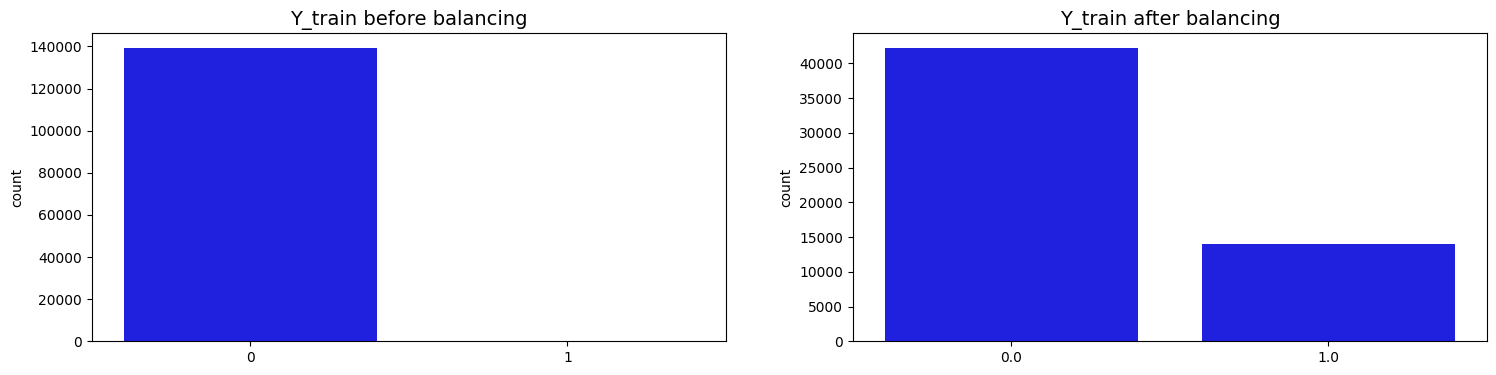

In [19]:
import warnings

# plotting
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Before rebalancing classes'''

sns.countplot(y_train, ax=ax[0], color='b')
ax[0].set_title('Y_train before balancing', fontsize=14)

''' After rebalancing classes'''

sns.countplot(y_train_resampled, ax=ax[1], color='b')
ax[1].set_title('Y_train after balancing', fontsize=14);

In [20]:
print(f'X_train_resampled.shape = {X_train_resampled.shape}')
print(f'X_val.shape = {X_val.shape}')

X_train_resampled.shape = (56138, 30)
X_val.shape = (59810, 30)


# Neural Network iterations

__Next steps__:

- Normalize the inputs:
    - use a __Normalization__ layer inside the model to 'pipeline' the preprocessing within the model.
    - or use sklearn's __StandardScaler__ outside of the model, applied to X_train, X_val and X_test.

    
- Make the model overfit, then regularize it using:
    - __Early Stopping__ criteria.
    - __Dropout__ layers.
    - __Regularizers__ layers.

In [21]:
from tensorflow import keras

metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

2024-02-22 17:37:16.736096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 17:37:17.146751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-22 17:37:17.146767: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-22 17:37:17.198824: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 17:37:18.251321: W tensorflow/stream_executor/platform/de

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision

def initialize_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # model compilation
    optimizer = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=metrics)
    
    return model